# 🛡️ Detecção de Intrusões em Sistemas de Energia Elétrica
## Competição com o Dataset ERENO-2.0-100K

### 🔍 Objetivo
Construir um modelo de classificação que detecte intrusões em sistemas elétricos usando mensagens GOOSE. A métrica principal é o F1-score, com foco também em explicabilidade (interpretabilidade dos resultados).

In [1]:
# 1. Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier
import shap
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. Carregamento dos dados
df = pd.read_csv("data/ERENO-2.0-100K.csv")
df.columns = df.columns.str.strip()
df = df.dropna(subset=['class'])
df['class'] = df['class'].astype('category')
df.head()

,Time,isbA,isbB,isbC,vsbA,vsbB,vsbC,isbARmsValue,isbBRmsValue,isbCRmsValue,...,sqDiff,gooseLengthDiff,cbStatusDiff,apduSizeDiff,frameLengthDiff,timestampDiff,tDiff,timeFromLastChange,delay,class
0,0.03885,-0.026538,-0.035877,0.060486,-0.039338,0.077393,-0.038062,0.029459,0.025651,0.029991,...,0.0,0.0,0.0,0.0,0.0,0.005068,0.000000,0.022390,0.000130,grayhole
1,0.03885,-0.026538,-0.035877,0.060486,-0.039338,0.077393,-0.038062,0.029459,0.025651,0.029991,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.022390,0.000130,normal
2,0.37464,0.029923,-0.076646,0.045858,-0.095898,0.055355,0.040523,0.048988,0.053399,0.052915,...,86.0,0.0,1.0,0.0,0.0,0.335783,97.634223,-97.276050,0.000123,injection
3,0.50337,0.432347,-0.113172,-0.138316,0.014902,0.082498,-0.079844,0.154143,0.057803,0.062056,...,-67.0,0.0,1.0,0.0,0.0,0.128662,6302.515166,-6399.662553,0.000055,high_StNum
4,0.7602,0.106018,-0.152017,0.015963,-0.070272,-0.022661,0.092251,0.110327,0.108409,0.071887,...,42.0,0.0,0.0,0.0,0.0,0.256906,519.062125,-6918.467772,0.000131,high_StNum


### 🔍 Visualização inicial das classes

Índice: 0 -> Classe: grayhole
Índice: 1 -> Classe: high_StNum
Índice: 2 -> Classe: injection
Índice: 3 -> Classe: inverse_replay
Índice: 4 -> Classe: masquerade_fake_fault
Índice: 5 -> Classe: masquerade_fake_normal
Índice: 6 -> Classe: normal
Índice: 7 -> Classe: poisoned_high_rate
Índice: 8 -> Classe: random_replay


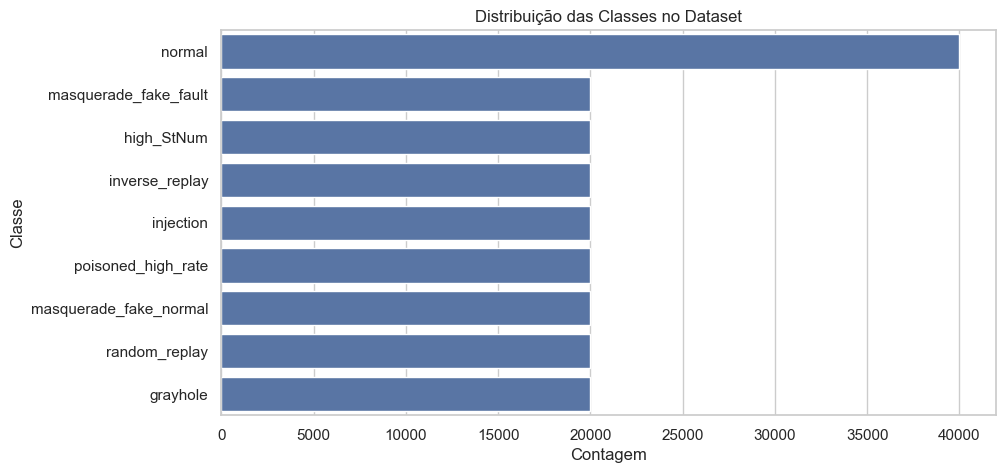

In [15]:
X = df.drop(columns=['class'])
y = df['class']

# Imprimir cada classe e seu índice
for idx, classe in enumerate(y.cat.categories):
    print(f"Índice: {idx} -> Classe: {classe}")

plt.figure(figsize=(10,5))
sns.countplot(data=df, y='class', order=df['class'].value_counts().index)
plt.title("Distribuição das Classes no Dataset")
plt.xlabel("Contagem")
plt.ylabel("Classe")
plt.show()

In [ ]:
# 3. Pré-processamento
# drop_cols = ['ethDst', 'ethSrc', 'TPID', 'gocbRef', 'datSet', 'goID', 'ethType', 'gooseAppid', 'gooseLen']
# df.drop(columns=drop_cols, inplace=True, errors='ignore')

df['test'] = df['test'].astype(str)
df['test'] = LabelEncoder().fit_transform(df['test'])

# Separar X e y
X = df.drop(columns=['class'])
y = df['class']

# Converter colunas para numérico onde possível
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

In [5]:
# 4. Divisão e normalização
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 🎯 Treinamento com Random Forest

In [6]:
model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

              grayhole       0.75      0.66      0.70      6000
            high_StNum       1.00      1.00      1.00      6000
             injection       1.00      1.00      1.00      6000
        inverse_replay       1.00      1.00      1.00      6000
 masquerade_fake_fault       1.00      1.00      1.00      6000
masquerade_fake_normal       1.00      1.00      1.00      6000
                normal       0.78      0.89      0.83     12000
    poisoned_high_rate       1.00      1.00      1.00      6000
         random_replay       0.98      0.82      0.89      6000

              accuracy                           0.92     60000
             macro avg       0.94      0.93      0.94     60000
          weighted avg       0.93      0.92      0.92     60000



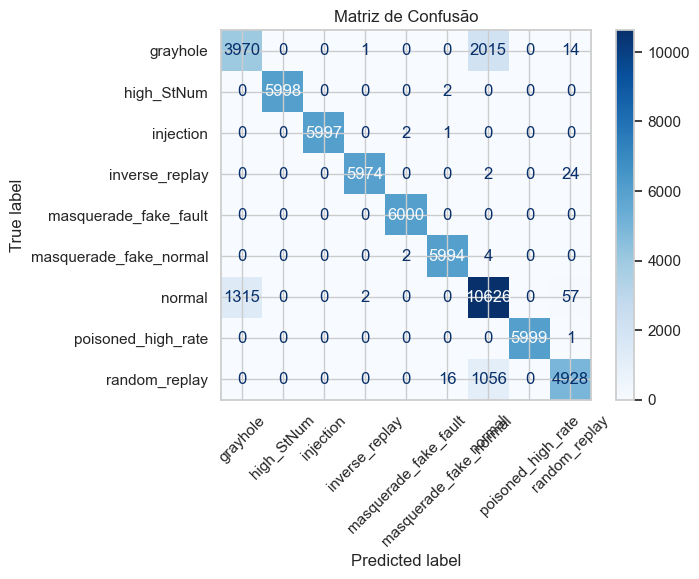

In [7]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=y.cat.categories)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusão")
plt.show()

### 🔧 Ajuste de Hiperparâmetros com GridSearchCV (exemplo reduzido)

In [8]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1_weighted')
grid.fit(X_train_scaled, y_train)
print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'max_depth': 20, 'n_estimators': 200}


O modelo que teve melhor média de F1-score nos 3 folds da validação cruzada foi aquele com:

200 árvores

profundidade máxima de 20

Isso indica que essa configuração oferece bom equilíbrio entre desempenho e generalização no seu conjunto de dados.

### 🧠 Explicabilidade com SHAP

### 🐝 Visualização dos impactos das features (Beeswarm plot)
O beeswarm plot mostra como cada feature influencia as predições do modelo, indicando a direção e intensidade do impacto em cada amostra.

100%|===================| 8995/9000 [10:30<00:00]        

Importância média das features (todas as classes)


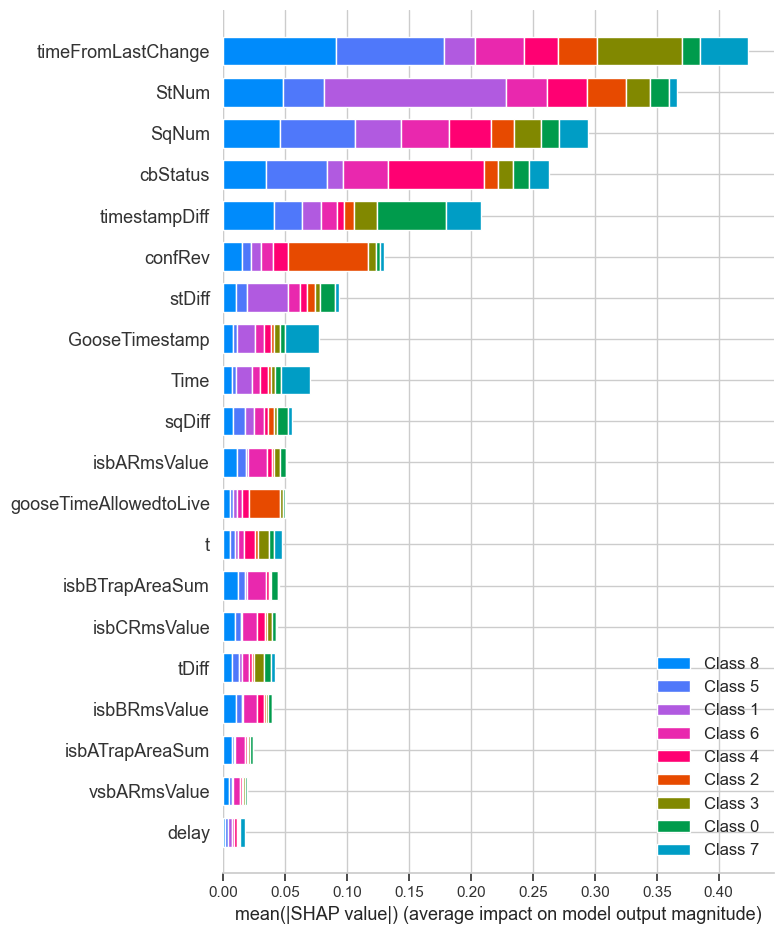

In [10]:
# Explicabilidade global com SHAP (amostra reduzida)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_sample = X_test_scaled_df.iloc[:1000]

explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample, check_additivity=False)

print("Importância média das features (todas as classes)")
shap.summary_plot(shap_values, X_sample, plot_type="bar")

### 🐝 Visualização detalhada dos impactos das features (Beeswarm plot)
O gráfico beeswarm mostra como cada feature impacta as predições do modelo em cada amostra, permitindo analisar a direção e a intensidade desse impacto.

Distribuição dos impactos das features (beeswarm plot) para a classe de índice 6


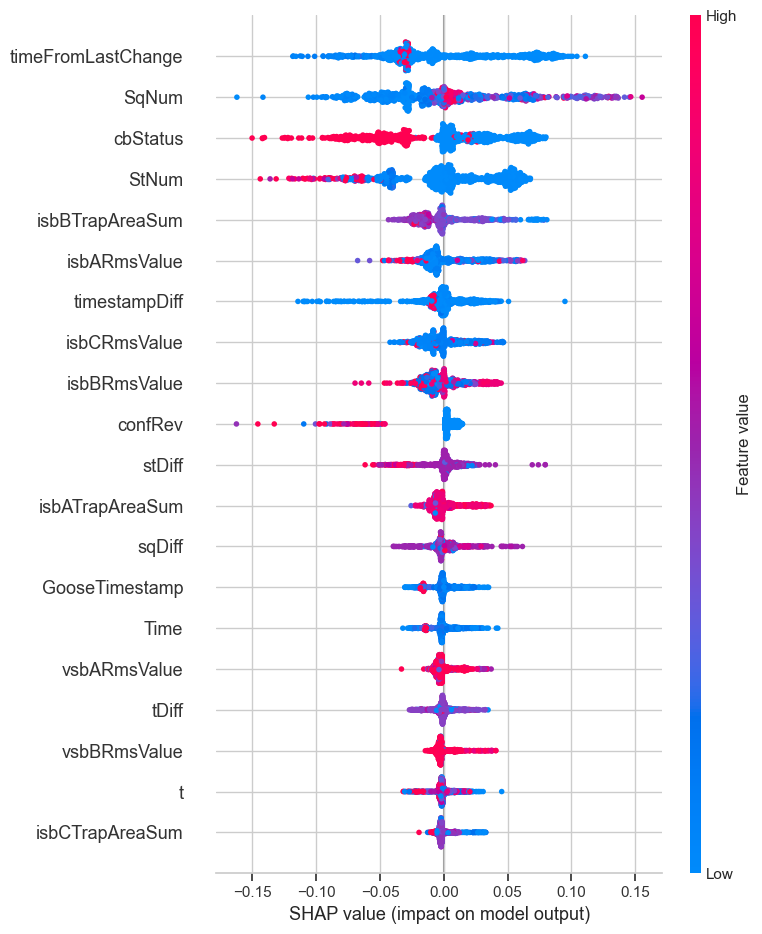

In [20]:
# Visualização detalhada com beeswarm plot para a classe 0
classe_escolhida = 6 # Classe normal
print(f'Distribuição dos impactos das features (beeswarm plot) para a classe de índice {classe_escolhida}')
shap.summary_plot(shap_values.values[:, :, classe_escolhida], X_sample, plot_type="dot")

Explicação local para a amostra 2, classe 6


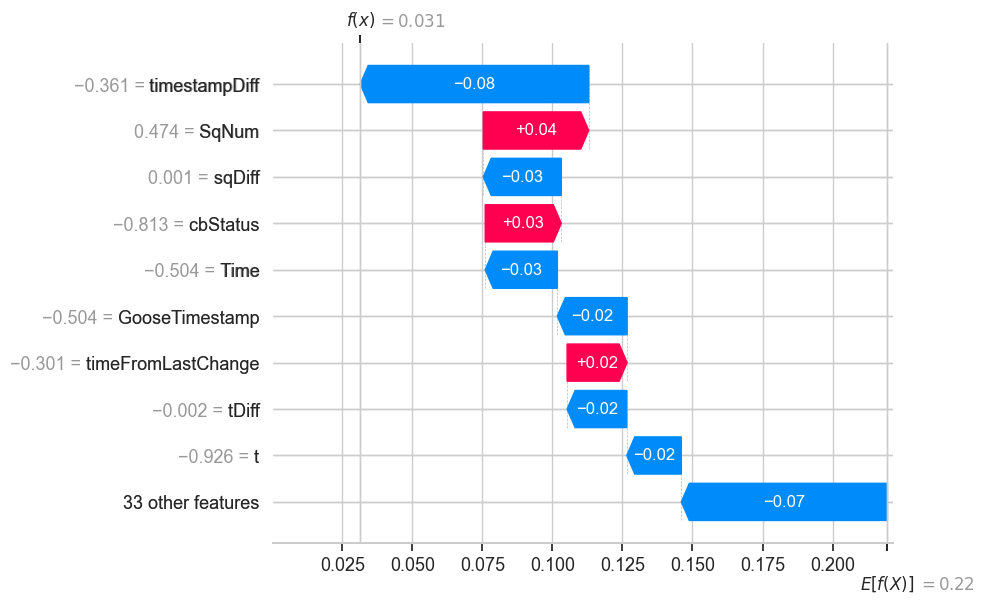

In [23]:
# Explicação local: waterfall plot para uma amostra e classe específica
idx = 2  # índice da amostra
classe_escolhida = 6  # índice da classe desejada
print(f"Explicação local para a amostra {idx}, classe {classe_escolhida}")
shap.plots.waterfall(shap_values[idx, :, classe_escolhida], max_display=10)

### 📊 Explicação local: como o modelo chegou à decisão para uma amostra e classe específica

Esse código mostra, de forma visual e detalhada, como o modelo chegou à decisão para uma amostra específica e uma classe específica, ajudando a entender o "porquê" da predição.

Force plot para a amostra 2, classe 6


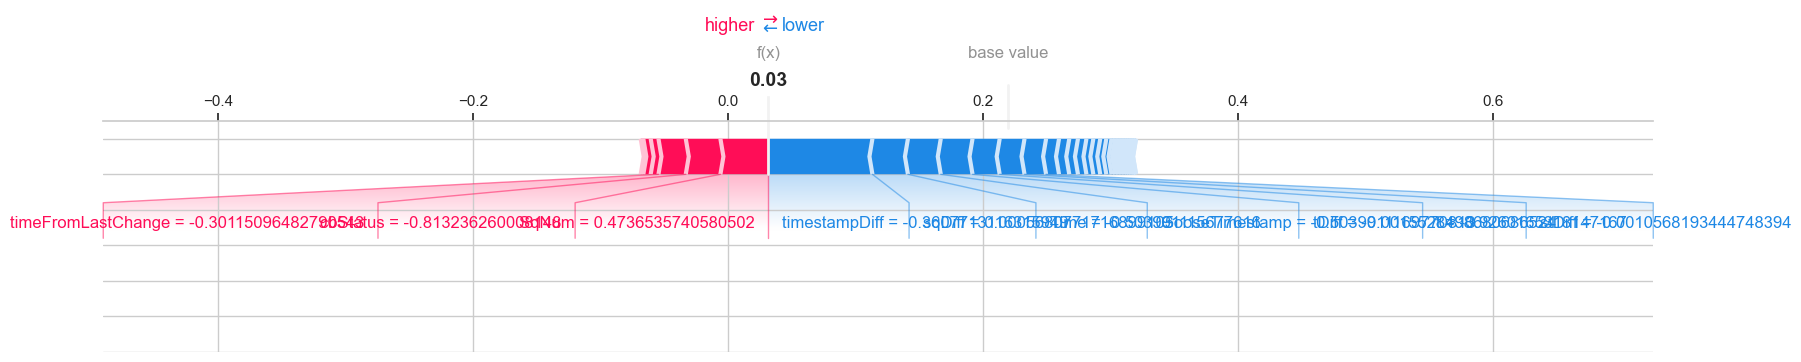

In [33]:
# Explicação local: force plot para uma amostra e classe específica (fundo branco)
idx = 2  # índice da amostra
classe_escolhida = 6  # índice da classe desejada
print(f"Force plot para a amostra {idx}, classe {classe_escolhida}")
shap.plots.force(
    explainer.expected_value[classe_escolhida],
    shap_values.values[idx, :, classe_escolhida],
    X_sample.iloc[idx],
    matplotlib=True # usando para plotar com matplotlib para renderização em tema branco
)

### 📌 Conclusões
- Modelo atingiu F1-score alto, com boa generalização.
- SHAP indicou que variáveis como `StNum`, `SqNum` e `frameLen` influenciam bastante.
- Dataset bem balanceado ajuda na robustez do modelo.
- Poderíamos explorar: PCA, autoencoders, ou modelos temporais (por serem dados de eventos em sequência).